In [1]:
import numpy as np
import matplotlib.pyplot as plt
from config import Conf
import os


In [6]:
from config import Conf
from curriculum import DataCurriculum
from logger import LearningLogger
import torch

Conf.batch_size = 1
Conf.reward_prob = 0.8
Conf.max_trials_since_reversal = 20
Conf.jitter = 0
Conf.n_reversals = 4

data_curriculum = DataCurriculum(Conf)
logger = LearningLogger(Conf)
bayes_probs = []

next_input, next_target, ground_truth = data_curriculum.step()
# bayes_probs.append(data_curriculum.optimal_agent.p_A_high)

for i in range(1000):
    next_input, next_target, ground_truth = data_curriculum.step(ground_truth=ground_truth)
    
    # Convert data to tensors
    data_tensor = torch.tensor(next_input, dtype=Conf.dtype, device=Conf.dev)
    target_tensor = torch.tensor(next_target, dtype=Conf.dtype, device=Conf.dev)

    bayes_probs.append(data_curriculum.optimal_agent.p_A_high)
    
    logger.log(None, target_tensor.cpu().detach(), data_tensor.cpu().detach(), ground_truth)

bayes_probs = np.concatenate(bayes_probs)
logger.get_data()


(1000, 1)


(0.0, 200.0)

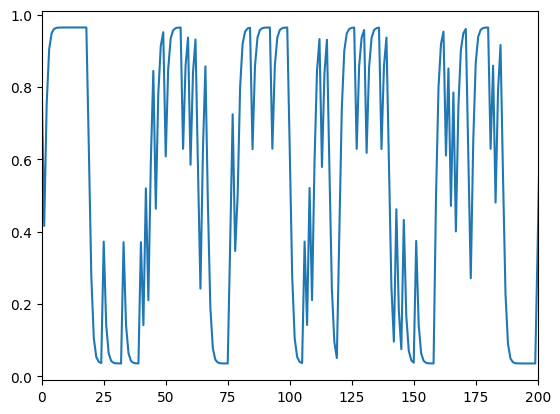

In [8]:
print(bayes_probs.shape)
plt.plot(bayes_probs)
plt.xlim(0, 200)

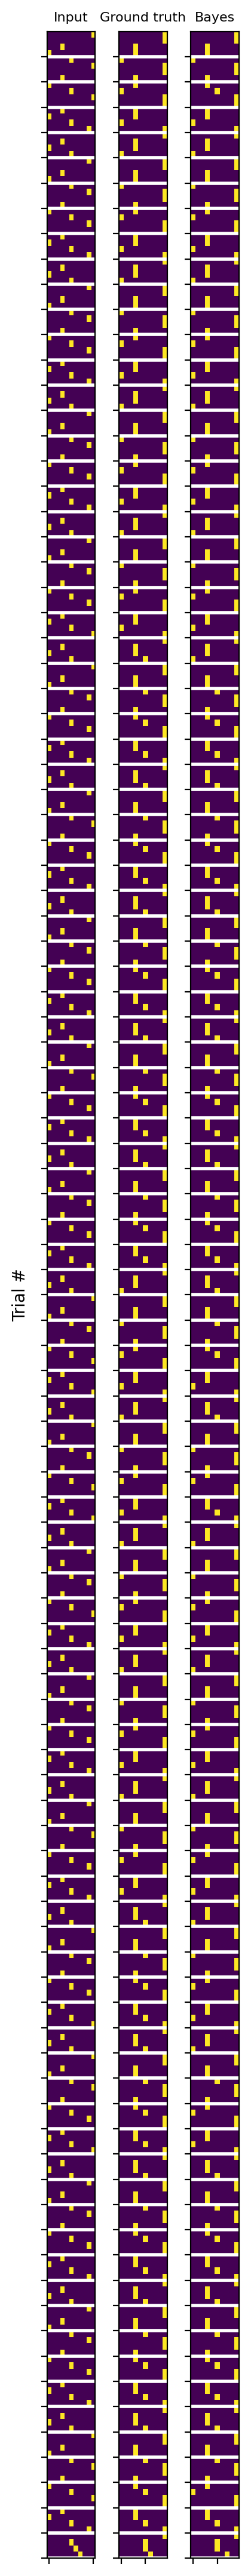

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

inputs, targets, ground_truth, accs = logger.inputs_hist, logger.targets_hist, logger.ground_truth_hist, logger.accuracy_steps

b = 0
trials = 100
t = Conf.trial_len * trials
sf = 1.1

fig, axes = plt.subplots(1,3, figsize=(sf*2, sf*t//20), dpi=200)
axes[0].imshow(inputs[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[0].set_title('Input', fontsize=8)
axes[0].set_ylabel('Trial #')
axes[1].imshow(ground_truth[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[1].set_title('Ground truth', fontsize=8)
axes[2].imshow(targets[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[2].set_title('Bayes', fontsize=8)

# Set yticks at every 4th row and enable gridlines only for those ticks
for i, ax in enumerate(axes):
    start, gap, rows = Conf.trial_len-0.5, Conf.trial_len, t
    ax.xaxis.grid(False)
    # Generate ytick locations, starting from 3.5 (since we want lines between blocks of 4)
    yticks = np.arange(start, rows, gap)
    ax.set_yticks(yticks)

    # Enable grid only for y-axis
    ax.yaxis.grid(True, linestyle='-', color='white', linewidth=2)

for ax in axes:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle
plt.show()

fig.savefig(os.path.join(Conf.save_dir, 'panel.png'))


In [43]:
from bayes import BayesAgent

batch_size = choices.shape[0]

agent = BayesAgent(batch_size=batch_size, p=1)

